In [1]:
import os
import gzip
import ijson
from pymatgen.io.lobster import Lobsterout
from pymatgen.core import Structure
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.electronic_structure.cohp import Cohp
from pymatgen.electronic_structure.cohp import CompleteCohp
from pymatgen.electronic_structure.plotter import CohpPlotter
from pymatgen.electronic_structure.dos import LobsterCompleteDos
from atomate2.lobster.schemas import LobsterTaskDocument

<h1><center>Top level keys to access data from Computational data JSON files </center></h1>
<table>
<thead>
  <tr>
    <th>Root Keys</th>
    <th>Data type</th>
    <th>Description</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>structure</td>
    <td>dict</td>
    <td>Dict representation of the pymatgen structure object<br>used for the LOBSTER calculation</td>
  </tr>
  <tr>
    <td>charges</td>
    <td>dict</td>
    <td>Atomic charges dict from LOBSTER based on <br>Mulliken and Loewdin charge analysis</td>
  </tr>
  <tr>
    <td>lobsterin</td>
    <td>dict</td>
    <td>LOBSTER calculation inputs</td>
  </tr>
  <tr>
    <td>lobsterout</td>
    <td>dict</td>
    <td>Information of LOBSTER calculation output</td>
  </tr>
  <tr>
    <td>lobsterpy_data</td>
    <td>dict</td>
    <td>Summarized bonding analysis data from Lobsterpy <br>(all bonds mode). It also includes Cohp objects <br>to plot the COHP curves from the automatic analysis</td>
  </tr>
  <tr>
    <td>lobsterpy_text</td>
    <td>dict</td>
    <td>LobsterPy automatic analysis summary text (all bonds mode)</td>
  </tr>
  <tr>
    <td>strongest_bonds_icohp</td>
    <td>dict</td>
    <td>Describes the strongest ICOHP bonds</td>
  </tr>
  <tr>
    <td>strongest_bonds_icoop</td>
    <td>dict</td>
    <td>Describes the strongest ICOOP bonds</td>
  </tr>
  <tr>
    <td>strongest_bonds_icobi</td>
    <td>dict</td>
    <td>Describes the strongest ICOBI bonds</td>
  </tr>
  <tr>
    <td>lobsterpy_data_cation_anion</td>
    <td>dict</td>
    <td>Summarized bonding analysis data from Lobsterpy <br>(cation-anion bonds mode). It also includes Cohp objects <br>to plot the COHP curves from the automatic analysis</td>
  </tr>
  <tr>
    <td>lobsterpy_text_cation_anion</td>
    <td>dict</td>
    <td>LobsterPy automatic analysis summary text <br>(cation-anion bonds mode)</td>
  </tr>
  <tr>
    <td>strongest_bonds_icohp_cation_anion</td>
    <td>dict</td>
    <td>Describes the strongest cation-anion ICOHP bonds</td>
  </tr>
  <tr>
    <td>strongest_bonds_icoop_cation_anion</td>
    <td>dict</td>
    <td>Describes the strongest cation-anion ICOOP bonds</td>
  </tr>
  <tr>
    <td>strongest_bonds_icobi_cation_anion</td>
    <td>dict</td>
    <td>Describes the strongest cation-anion ICOBI bonds</td>
  </tr>
  <tr>
    <td>cohp_data</td>
    <td>dict</td>
    <td>Dict representation of pymatgen CompleteCohp object <br>including data to plot COHP curves</td>
  </tr>
  <tr>
    <td>coop_data</td>
    <td>dict</td>
    <td>Dict representation of pymatgen CompleteCohp object <br>including data to plot COOP curves</td>
  </tr>
  <tr>
    <td>cobi_data</td>
    <td>dict</td>
    <td>Dict representation of pymatgen CompleteCohp object <br>including data to plot COBI curves</td>
  </tr>
  <tr>
    <td>dos</td>
    <td>dict</td>
    <td>Dict representation of pymatgen LobsterCompleteDos object <br>including the DOSCAR.lobster data</td>
  </tr>
  <tr>
    <td>lso_dos</td>
    <td>dict</td>
    <td>Dict representation of pymatgen LobsterCompleteDos object <br>including the DOSCAR.LSO.lobster data</td>
  </tr>
  <tr>
    <td>madelung_energies</td>
    <td>dict</td>
    <td>Consists of the Madelung energies of the structure derived from <br>the Mulliken and Löwdin charges</td>
  </tr>
</tbody>
</table>

### Function below can reads one Root key data from the json at a time. Due to file large sizes it is recommended approach to avoid running of out memory issues 

In [2]:
def read_lobstertask_doc_json(filename: str,pymatgen_objs: bool=False, query='structure'):
    """
    This function loads the lobster task json.gz files and returns a dictionary corresponding to query.
    
    Args:
        filename (str) : name of file
        pymatgen_objs (bool) : if True will convert structure,coop,cobi,cohp and dos to pymatgen objects
        query (str) : Filters the json file based on this key and returns data corresponding to it.  
        Possible query corresponds to root keys column of the table above.
    Returns:
        Returns a dictionary with lobster task json data corresponding to query.
    """
    lobster_data={}
    with gzip.open(filename, 'rb') as f:
        objects = ijson.items(f,'item',use_float=True)
        #filtered_objects = (obj for obj in objects if list(obj.keys())[0]==query)
        for obj in objects:
            if query in obj:
                for k, v in obj.items():
                    if pymatgen_objs:
                        if k=='structure':
                            lobster_data[k]=Structure.from_dict(v)
                        elif k=='lobsterpy_data' or k=='lobsterpy_data_cation_anion':
                            lobster_data[k]=v
                            if lobster_data[k]:
                                for plotlabel, cohp in lobster_data[k]["cohp_plot_data"].items():
                                    lobster_data[k]["cohp_plot_data"][plotlabel]= Cohp.from_dict(cohp)
                        elif k=='cohp_data' or k=='cobi_data' or k=='coop_data':
                            lobster_data[k]=CompleteCohp.from_dict(v)
                        elif k=='lso_dos' or k=='dos':
                            lobster_data[k]=LobsterCompleteDos.from_dict(v)
                        else:
                            lobster_data[k]=v
                    else:
                        lobster_data[k]=v
                break
                    
    return lobster_data

### Section below provides some example snippets of how to access some data from the computational data json based on keys

In [3]:
#get structure
lobtask= read_lobstertask_doc_json(filename='../Example_data/Computational_data_jsons/mp-1008223.json.gz', 
                                   pymatgen_objs=True, query='structure')
lobtask['structure']

Structure Summary
Lattice
    abc : 4.666904755831213 4.666904755831213 4.666904755831213
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 71.874
      A : 0.0 3.3 3.3
      B : 3.3 0.0 3.3
      C : 3.3 3.3 0.0
    pbc : True True True
PeriodicSite: Ca (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Se (1.6500, 1.6500, 1.6500) [0.2500, 0.2500, 0.2500]

In [4]:
#get lobsterpy summary analysis summary text
lobtask= read_lobstertask_doc_json(filename='../Example_data/Computational_data_jsons/mp-1008223.json.gz', 
                                   pymatgen_objs=True, query='lobsterpy_text')
lobtask['lobsterpy_text']

'The compound CaSe has 2 symmetry-independent atoms(s) with relevant bonds: Ca1, Se2. Ca1 has a tetrahedral (CN=4) coordination environment. It has 4 Ca-Se (mean ICOHP: -0.83 eV, 10.922 percent antibonding interaction below EFermi) bonds. Se2 has a tetrahedral (CN=4) coordination environment. It has 4 Se-Ca (mean ICOHP: -0.83 eV, 10.922 percent antibonding interaction below EFermi) bonds.'

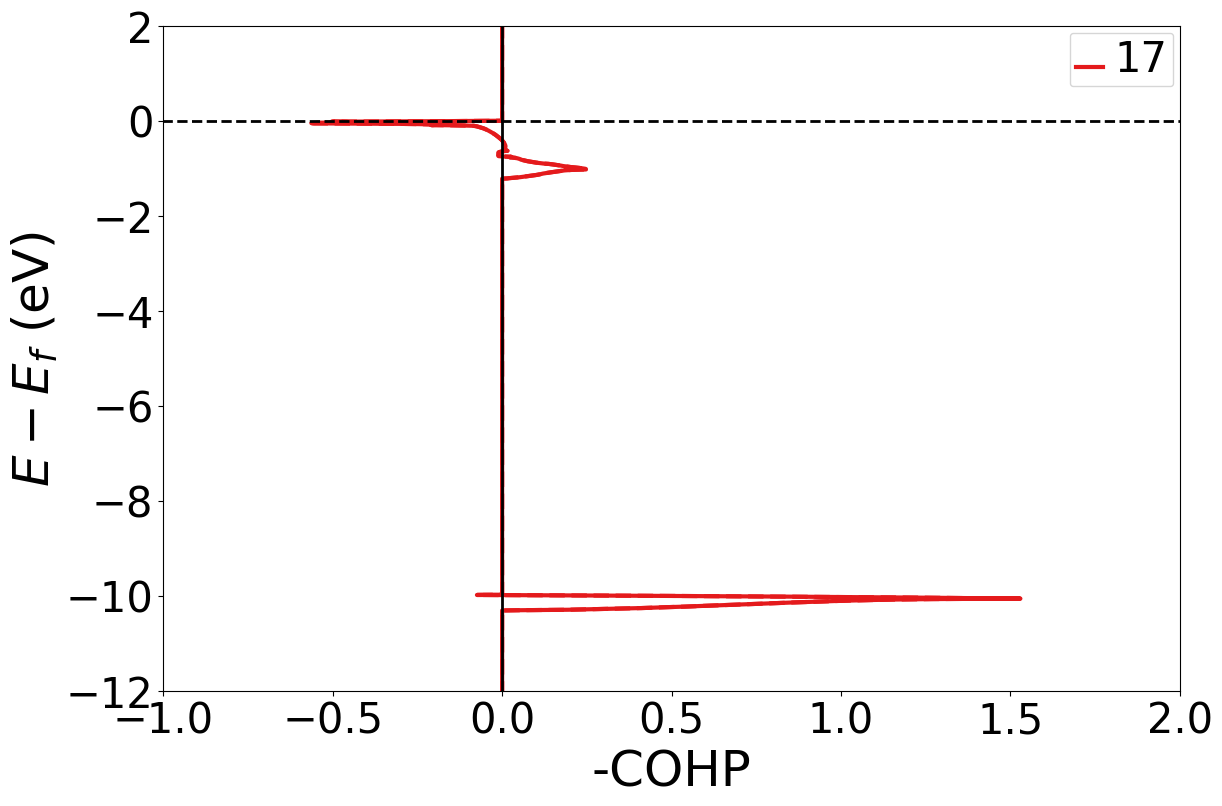

In [5]:
#get lobster cohpcar pymatgen object and plot cohp by label
lobtask= read_lobstertask_doc_json(filename='../Example_data/Computational_data_jsons/mp-1008223.json.gz', 
                                   pymatgen_objs=True, query='cohp_data')
cohppplot = CohpPlotter()
cohppplot.add_cohp(label='17',cohp=lobtask['cohp_data'].get_cohp_by_label('17')) #plot cohp by bond label
plot = cohppplot.get_plot(integrated=False)
plot.ylim([-12, 2])
plot.xlim([-1, 2])
plot.show()

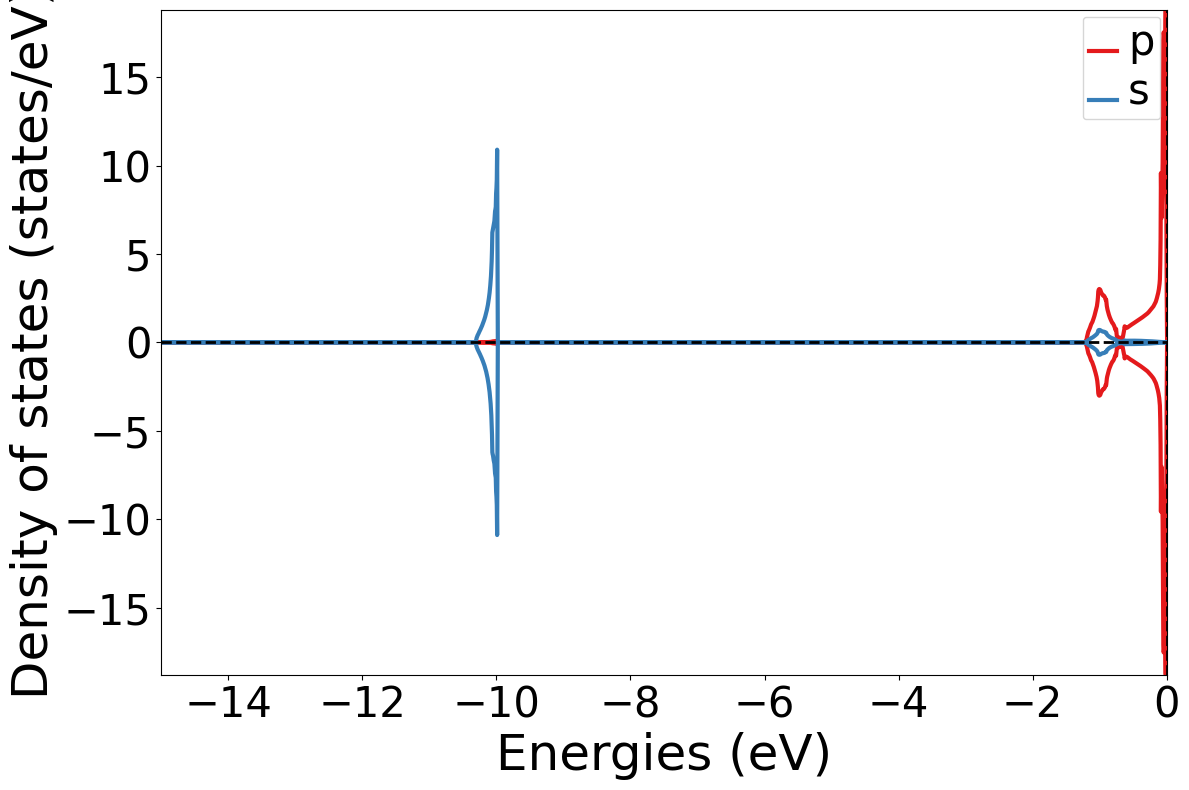

In [6]:
#get lobster dos pymatgen object and plot projected dos
lobtask= read_lobstertask_doc_json(filename='../Example_data/Computational_data_jsons/mp-1008223.json.gz', 
                                   pymatgen_objs=True, query='lso_dos')
plotter = DosPlotter()
plotter.add_dos_dict(lobtask['lso_dos'].get_spd_dos())
plotter.get_plot(xlim=(-15, 0));